### Libraries

In [2]:
import cv2
import os
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
import csv
import time
from datetime import datetime
import joblib

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

### Collecting Data

In [2]:
video=cv2.VideoCapture(0)
facedetect=cv2.CascadeClassifier(r'E:\data_science_files\files\frontalface.xml')

faces_data=[]

i=0

name=input("Enter Your Name: ")

while True:
    ret,frame=video.read()
    gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces=facedetect.detectMultiScale(gray, 1.3 ,5)
    for (x,y,w,h) in faces:
        crop_img=frame[y:y+h, x:x+w, :]
        resized_img=cv2.resize(crop_img, (128,128))
        resized_img=np.array(resized_img)
        if len(faces_data)<=500 and i%10==0:
            faces_data.append(resized_img)
        i=i+1
        cv2.putText(frame, str(len(faces_data)), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 1)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255,255,255), 3)
    cv2.imshow("Frame",frame)
    k=cv2.waitKey(1)
    if k==ord('q') or len(faces_data)==500:
        break
video.release()
cv2.destroyAllWindows()

faces_data=np.asarray(faces_data)


if 'names.pkl' not in os.listdir('data/'):
    names=[name]*500
    with open('data/names.pkl', 'wb') as f:
        pickle.dump(names, f)
else:
    with open('data/names.pkl', 'rb') as f:
        names=pickle.load(f)
    names=names+[name]*500
    with open('data/names.pkl', 'wb') as f:
        pickle.dump(names, f)

if 'faces_data.pkl' not in os.listdir('data/'):
    with open('data/faces_data.pkl', 'wb') as f:
        pickle.dump(faces_data, f)
else:
    with open('data/faces_data.pkl', 'rb') as f:
        faces=pickle.load(f)
    faces=np.append(faces, faces_data, axis=0)
    with open('data/faces_data.pkl', 'wb') as f:
        pickle.dump(faces, f)

Enter Your Name: Anjana


### Processing And Modeling Data

In [3]:
with open('data/names.pkl', 'rb') as w:
    label=pickle.load(w)
with open('data/faces_data.pkl', 'rb') as f:
    data=pickle.load(f)
print('Shape of Faces matrix --> ', data.shape)

Shape of Faces matrix -->  (2000, 128, 128, 3)


In [4]:
print('datas - ',len(data))
print('labels - ',len(label))

datas -  2000
labels -  2000


In [5]:
set(label)

{'Ajmal', 'Anjana', 'Ashiqu', 'Azra'}

### Label Encoding

In [6]:
encoder=LabelEncoder()
enc_label=encoder.fit_transform(label)

### Splitting as Value and Target

In [7]:
X=np.array(data)
y=np.array(enc_label)

In [8]:
X=X/255

### Testing 

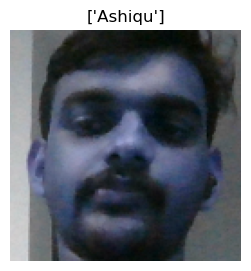

In [9]:
start = 0
end = len(data)-1
random_number = random.randint(start, end)
plt.figure(figsize=(4,3))
plt.imshow(X[random_number])
plt.title(encoder.inverse_transform([y[random_number]]))
plt.axis('Off')
plt.show()

In [10]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(128,128,3),strides=(2,2),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense((len(data)/500),activation='softmax'))

In [10]:
model.compile(loss='SparseCategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                        

In [13]:
trained_history=model.fit(X,y,batch_size=200,epochs=5)

Epoch 1/5
10/10 [==============================] - 36s 3s/step - loss: 1.2225 - accuracy: 0.4075
Epoch 2/5
10/10 [==============================] - 33s 3s/step - loss: 0.5054 - accuracy: 0.8455
Epoch 3/5
10/10 [==============================] - 33s 3s/step - loss: 0.2082 - accuracy: 0.9585
Epoch 4/5
10/10 [==============================] - 35s 3s/step - loss: 0.1201 - accuracy: 0.9765
Epoch 5/5
10/10 [==============================] - 34s 3s/step - loss: 0.0755 - accuracy: 0.9865


### Loss,Accuracy

In [14]:
tr_loss,tr_accuracy=model.evaluate(X,y)
print('Train Accuracy: ',tr_accuracy*100)
print('Train Loss: ',tr_loss*100)

63/63 [==============================] - 9s 140ms/step - loss: 0.0483 - accuracy: 0.9925
Train Accuracy:  99.25000071525574
Train Loss:  4.826616868376732


In [15]:
s_val=encoder.classes_
i_val=encoder.transform(encoder.classes_)
combine=dict(zip(i_val,s_val))
combine

{0: 'Ajmal', 1: 'Anjana', 2: 'Ashiqu', 3: 'Azra'}

### Saving Model

In [16]:
joblib.dump(model,'Models/detect.joblib') 

['Models/detect.joblib']

In [17]:
joblib.dump(combine,'Models/vals')

['Models/vals']

### Attendence

In [33]:
# model=joblib.load('./Models/detect1.joblib')
vals=joblib.load('./Models/vals')

In [34]:
from win32com.client import Dispatch

def speak(str1):
    speak=Dispatch(("SAPI.SpVoice"))
    speak.Speak(str1)
    
video=cv2.VideoCapture(0)
facedetect=cv2.CascadeClassifier(r'C:\Users\user\anaconda3\Lib\site-packages\cv2\data\haarcascade_frontalface_default.xml')
print('Capturing.....')
COL_NAMES = ['NAME', 'TIME']
while True:
    ret,frame=video.read()
    gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces=facedetect.detectMultiScale(gray, 1.3 ,5)
    for (x,y,w,h) in faces:
        crop_img=frame[y:y+h, x:x+w, :]
        resized_img=cv2.resize(crop_img, (128,128))
        arr_img=np.array(resized_img)
        reshaped_img=arr_img.reshape(-1,128,128,3)
        output=np.argmax(model.predict([reshaped_img]))
        if output<len(vals):
            name=output
            name=vals[int(output)]
            ts=time.time()
            date=datetime.fromtimestamp(ts).strftime("%d-%m-%Y")
            timestamp=datetime.fromtimestamp(ts).strftime("%H:%M-%S")
            exist=os.path.isfile("Attendance/Attendance_" + date + ".csv")
            cv2.putText(frame,str(name), (128,128), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,0), 4)
            attendance=[str(name), str(timestamp)]
    cv2.imshow("Frame",frame)
    k=cv2.waitKey(1)
    if k==ord('o'):
        speak('Attendance Taken..')
        if exist:
            with open("Attendance/Attendance_" + date + ".csv", "+a") as csvfile:
                writer=csv.writer(csvfile)
                writer.writerow(attendance)
            csvfile.close()
        else:
            with open("Attendance/Attendance_" + date + ".csv", "+a") as csvfile:
                writer=csv.writer(csvfile)
                writer.writerow(COL_NAMES)
                writer.writerow(attendance)
            csvfile.close()
    if k==ord('q'):
        break
video.release()
cv2.destroyAllWindows()

Capturing.....
1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 33ms/step
